### VAE(Variational Autoencoder) is a powerful tool in manifold visualization and generate new samples mimicing the data, here we investigate training a VAE on different datasets and compare them with the original fitting.

In [1]:
import sklearn
import numpy as np
import pandas as pd
import json
import rpy2
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA, PCA
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from sklearn.model_selection import StratifiedKFold
from tensorflow.python.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras import regularizers,initializers
from tensorflow.python.keras.layers import Lambda, Input, Dense, Dropout,GaussianNoise,Lambda,Flatten,Activation,concatenate
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam,Adamax,Adadelta,Adagrad,RMSprop,SGD
from tensorflow.python.keras.models import Model

In [2]:
dataA_ = pd.read_csv('A_data.csv', sep = ' ')
dataB_ = pd.read_csv('B_data.csv', sep = ' ')
whole_data = pd.concat([dataA_, dataB_], axis = 0)

In [74]:
A_df = pd.DataFrame(dataA_)
B_df = pd.DataFrame(dataB_)
[n_A, n_1] = dataB_.shape
[n_B, n_1] = dataA_.shape

In [4]:
#####
#Variational Autoencoder for the manifold extraction:
def VAE_DR(original_dim, inter_dim, latent_dim, Name = 'No.1'):
    input_shape = (original_dim, )
    inputs = Input(shape = input_shape, name = 'encoder_input' + Name)
    
    #Two layers' vae:
    x = Dense(inter_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3),
             kernel_initializer = keras.initializers.glorot_uniform())(inputs)
    x = Dropout(0.4)(x)
    z_mean = Dense(latent_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3),
                  name = 'z_mean' + Name, kernel_initializer = keras.initializers.glorot_uniform())(x)
    z_log_var = Dense(latent_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3),
                     kernel_initializer = keras.initializers.glorot_uniform())(x)
    ##
    #Sampling the latent space:
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch, dim))
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output
    z = Lambda(sampling, output_shape = (latent_dim), name = 'Sampling_layer' + Name)([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name = 'Encoder'+ Name)
    ######
    #Decoder part:
    latent_inputs = Input(shape = (latent_dim, ), name = 'Z' + Name)
    x = Dense(inter_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3), 
              kernel_initializer = keras.initializers.glorot_uniform())(latent_inputs)
    x = Dropout(0.2)(x)
    output = Dense(original_dim, activation = 'relu', kernel_regularizer = regularizers.l2(1e-3),
                   kernel_initializer = keras.initializers.glorot_uniform())(x)
    ##
    decoder = Model(latent_inputs, output, name = 'decoder'+ Name)
    outputs = decoder(encoder(inputs)[2])
    VAE_model = Model(inputs, outputs, name = 'vae_mlp' + Name)
    #
    models = (encoder, decoder)
    #####
    #Add loss:
    recon_loss = losses.mean_squared_error(outputs, inputs)
    recon_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis = -1)
    kl_loss *= -0.5
    #The VAE loss consists of reconstruction loss and kl loss(kl divergence 
    #between the approximate posterior and true posterior)
    vae_loss = K.mean(recon_loss + kl_loss)
    VAE_model.add_loss(vae_loss)
    OPTIM = Adam(lr = 5e-5)
    VAE_model.compile(optimizer = OPTIM)
    return encoder, decoder, VAE_model
    

In [5]:
#VAE training for the first population:
encoder1, decoder1, VAE_model1 = VAE_DR(n_1, 40, 2)
#Train the model:
callbacks = [EarlyStopping(monitor='val_loss', patience = 80)]
VAE_model1.fit(dataA_, epochs = 4000, callbacks = callbacks, validation_split = 0.2, shuffle = True)
#Apply the generative nature to generate new samples for this cell population:
[z_mean1, z_log_var1, latent_generation1] = encoder1.predict(dataA_)
random_gene1 = np.random.normal(0, 1, [100, 2])
generation1 = decoder1.predict(random_gene1)

W0730 23:38:02.941603 4624049600 deprecation.py:506] From /Users/ruanhq/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0730 23:38:03.285815 4624049600 training_utils.py:1101] Output decoderNo.1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoderNo.1.


Train on 2018 samples, validate on 505 samples
Epoch 1/4000
2018/2018 [==============================] - 1s 351us/sample - loss: 116003428.8477 - val_loss: 2071.9531
Epoch 2/4000
2018/2018 [==============================] - 0s 121us/sample - loss: 777676.4561 - val_loss: 2072.5892
Epoch 3/4000
2018/2018 [==============================] - 0s 130us/sample - loss: 842070769.7258 - val_loss: 2071.9878
Epoch 4/4000
2018/2018 [==============================] - 0s 118us/sample - loss: 30844.9286 - val_loss: 2071.7789
Epoch 5/4000
2018/2018 [==============================] - 0s 116us/sample - loss: 14831.6569 - val_loss: 2070.4249
Epoch 6/4000
2018/2018 [==============================] - 0s 115us/sample - loss: 2395665.6562 - val_loss: 2069.0115
Epoch 7/4000
2018/2018 [==============================] - 0s 120us/sample - loss: 160805.9032 - val_loss: 2067.1696
Epoch 8/4000
2018/2018 [==============================] - 0s 113us/sample - loss: 13911.9329 - val_loss: 2064.7674
Epoch 9/4000
2018/201

2018/2018 [==============================] - 0s 114us/sample - loss: 13201.5626 - val_loss: 1946.4758
Epoch 72/4000
2018/2018 [==============================] - 0s 117us/sample - loss: 13198.4589 - val_loss: 1942.2028
Epoch 73/4000
2018/2018 [==============================] - 0s 113us/sample - loss: 13769.2468 - val_loss: 1939.3827
Epoch 74/4000
2018/2018 [==============================] - 0s 117us/sample - loss: 13171.4052 - val_loss: 1938.2769
Epoch 75/4000
2018/2018 [==============================] - 0s 114us/sample - loss: 13125.1916 - val_loss: 1932.8337
Epoch 76/4000
2018/2018 [==============================] - 0s 111us/sample - loss: 13137.0471 - val_loss: 1931.1158
Epoch 77/4000
2018/2018 [==============================] - 0s 111us/sample - loss: 45049.2171 - val_loss: 1927.4381
Epoch 78/4000
2018/2018 [==============================] - 0s 112us/sample - loss: 13171.3988 - val_loss: 1925.3716
Epoch 79/4000
2018/2018 [==============================] - 0s 111us/sample - loss: 130

2018/2018 [==============================] - 0s 115us/sample - loss: 9771.8940 - val_loss: 1447.7349
Epoch 142/4000
2018/2018 [==============================] - 0s 117us/sample - loss: 9637.5973 - val_loss: 1434.9824
Epoch 143/4000
2018/2018 [==============================] - 0s 107us/sample - loss: 11339.0086 - val_loss: 1425.9593
Epoch 144/4000
2018/2018 [==============================] - 0s 108us/sample - loss: 12454.2079 - val_loss: 1409.7332
Epoch 145/4000
2018/2018 [==============================] - 0s 110us/sample - loss: 9373.8766 - val_loss: 1397.5706
Epoch 146/4000
2018/2018 [==============================] - 0s 107us/sample - loss: 9281.2512 - val_loss: 1387.6524
Epoch 147/4000
2018/2018 [==============================] - 0s 105us/sample - loss: 9121.2140 - val_loss: 1375.6613
Epoch 148/4000
2018/2018 [==============================] - 0s 104us/sample - loss: 9121.4224 - val_loss: 1364.8402
Epoch 149/4000
2018/2018 [==============================] - 0s 109us/sample - loss: 8

2018/2018 [==============================] - 0s 108us/sample - loss: 6868.7367 - val_loss: 1164.2239
Epoch 212/4000
2018/2018 [==============================] - 0s 106us/sample - loss: 6787.3566 - val_loss: 1166.1452
Epoch 213/4000
2018/2018 [==============================] - 0s 110us/sample - loss: 6844.0532 - val_loss: 1166.5105
Epoch 214/4000
2018/2018 [==============================] - 0s 105us/sample - loss: 6759.8253 - val_loss: 1167.2631
Epoch 215/4000
2018/2018 [==============================] - 0s 112us/sample - loss: 6767.9455 - val_loss: 1160.3241
Epoch 216/4000
2018/2018 [==============================] - 0s 112us/sample - loss: 6761.5905 - val_loss: 1157.8920
Epoch 217/4000
2018/2018 [==============================] - 0s 109us/sample - loss: 6749.4006 - val_loss: 1161.1774
Epoch 218/4000
2018/2018 [==============================] - 0s 107us/sample - loss: 6754.4690 - val_loss: 1163.7776
Epoch 219/4000
2018/2018 [==============================] - 0s 106us/sample - loss: 674

Epoch 282/4000
2018/2018 [==============================] - 0s 106us/sample - loss: 6362.8654 - val_loss: 1151.8323
Epoch 283/4000
2018/2018 [==============================] - 0s 105us/sample - loss: 6369.5445 - val_loss: 1142.0901
Epoch 284/4000
2018/2018 [==============================] - 0s 106us/sample - loss: 6348.3686 - val_loss: 1145.2357
Epoch 285/4000
2018/2018 [==============================] - 0s 106us/sample - loss: 6379.8318 - val_loss: 1150.4299
Epoch 286/4000
2018/2018 [==============================] - 0s 109us/sample - loss: 6334.9264 - val_loss: 1153.8258
Epoch 287/4000
2018/2018 [==============================] - 0s 106us/sample - loss: 6348.1657 - val_loss: 1149.9160
Epoch 288/4000
2018/2018 [==============================] - 0s 107us/sample - loss: 6339.8096 - val_loss: 1147.4241
Epoch 289/4000
2018/2018 [==============================] - 0s 108us/sample - loss: 6341.4458 - val_loss: 1145.7460
Epoch 290/4000
2018/2018 [==============================] - 0s 105us/sam

2018/2018 [==============================] - 0s 106us/sample - loss: 6179.2565 - val_loss: 1151.0841
Epoch 353/4000
2018/2018 [==============================] - 0s 107us/sample - loss: 6132.1865 - val_loss: 1146.5238
Epoch 354/4000
2018/2018 [==============================] - 0s 107us/sample - loss: 6145.0233 - val_loss: 1149.2432
Epoch 355/4000
2018/2018 [==============================] - 0s 105us/sample - loss: 6119.6195 - val_loss: 1145.1048
Epoch 356/4000
2018/2018 [==============================] - 0s 106us/sample - loss: 6186.0564 - val_loss: 1156.1286
Epoch 357/4000
2018/2018 [==============================] - 0s 105us/sample - loss: 6162.1471 - val_loss: 1150.5605
Epoch 358/4000
2018/2018 [==============================] - 0s 106us/sample - loss: 6113.5011 - val_loss: 1158.0702
Epoch 359/4000
2018/2018 [==============================] - 0s 106us/sample - loss: 6136.7115 - val_loss: 1149.3908
Epoch 360/4000
2018/2018 [==============================] - 0s 107us/sample - loss: 614

In [6]:
#VAE training for the first population:
encoder2, decoder2, VAE_model2 = VAE_DR(n_1, 40, 2)
#Train the model:
callbacks = [EarlyStopping(monitor='val_loss', patience = 80)]
VAE_model1.fit(dataB_, epochs = 4000, callbacks = callbacks, validation_split = 0.2, shuffle = True)
#Apply the generative nature to generate new samples for this cell population:
[z_mean2, z_log_var2, latent_generation2] = encoder1.predict(dataB_)
random_gene2 = np.random.normal(0, 1, [500, 2])
generation2 = decoder2.predict(random_gene2)


W0730 23:39:34.535393 4624049600 training_utils.py:1101] Output decoderNo.1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoderNo.1.


Train on 1803 samples, validate on 451 samples
Epoch 1/4000
1803/1803 [==============================] - 0s 149us/sample - loss: 7259.1454 - val_loss: 1289.9108
Epoch 2/4000
1803/1803 [==============================] - 0s 109us/sample - loss: 6601.5539 - val_loss: 1257.8446
Epoch 3/4000
1803/1803 [==============================] - 0s 109us/sample - loss: 6405.4749 - val_loss: 1222.4179
Epoch 4/4000
1803/1803 [==============================] - 0s 107us/sample - loss: 6256.0009 - val_loss: 1210.9776
Epoch 5/4000
1803/1803 [==============================] - 0s 107us/sample - loss: 6168.6519 - val_loss: 1193.5148
Epoch 6/4000
1803/1803 [==============================] - 0s 108us/sample - loss: 6051.4058 - val_loss: 1178.6327
Epoch 7/4000
1803/1803 [==============================] - 0s 109us/sample - loss: 5974.4877 - val_loss: 1167.5291
Epoch 8/4000
1803/1803 [==============================] - 0s 108us/sample - loss: 5883.8618 - val_loss: 1169.1406
Epoch 9/4000
1803/1803 [=================

1803/1803 [==============================] - 0s 105us/sample - loss: 4084.3823 - val_loss: 922.9204
Epoch 73/4000
1803/1803 [==============================] - 0s 107us/sample - loss: 4101.3000 - val_loss: 926.4703
Epoch 74/4000
1803/1803 [==============================] - 0s 108us/sample - loss: 4053.2402 - val_loss: 927.8122
Epoch 75/4000
1803/1803 [==============================] - 0s 108us/sample - loss: 4102.3981 - val_loss: 929.2114
Epoch 76/4000
1803/1803 [==============================] - 0s 106us/sample - loss: 4082.4132 - val_loss: 932.3112
Epoch 77/4000
1803/1803 [==============================] - 0s 109us/sample - loss: 4072.1703 - val_loss: 918.2373
Epoch 78/4000
1803/1803 [==============================] - 0s 104us/sample - loss: 4024.6345 - val_loss: 922.1111
Epoch 79/4000
1803/1803 [==============================] - 0s 107us/sample - loss: 4034.8582 - val_loss: 922.4075
Epoch 80/4000
1803/1803 [==============================] - 0s 107us/sample - loss: 4039.5038 - val_los

1803/1803 [==============================] - 0s 122us/sample - loss: 3860.7731 - val_loss: 898.1888
Epoch 144/4000
1803/1803 [==============================] - 0s 121us/sample - loss: 3891.2555 - val_loss: 906.3392
Epoch 145/4000
1803/1803 [==============================] - 0s 117us/sample - loss: 3849.6506 - val_loss: 912.8618
Epoch 146/4000
1803/1803 [==============================] - 0s 109us/sample - loss: 3872.6229 - val_loss: 908.9161
Epoch 147/4000
1803/1803 [==============================] - 0s 108us/sample - loss: 3865.3845 - val_loss: 904.5117
Epoch 148/4000
1803/1803 [==============================] - 0s 105us/sample - loss: 3865.0692 - val_loss: 904.9863
Epoch 149/4000
1803/1803 [==============================] - 0s 121us/sample - loss: 3877.8267 - val_loss: 905.2357
Epoch 150/4000
1803/1803 [==============================] - 0s 118us/sample - loss: 3840.4359 - val_loss: 905.5219
Epoch 151/4000
1803/1803 [==============================] - 0s 116us/sample - loss: 3866.0264 -

1803/1803 [==============================] - 0s 118us/sample - loss: 3813.0493 - val_loss: 893.1338
Epoch 215/4000
1803/1803 [==============================] - 0s 113us/sample - loss: 3806.5183 - val_loss: 901.1402
Epoch 216/4000
1803/1803 [==============================] - 0s 115us/sample - loss: 3798.5769 - val_loss: 904.3459
Epoch 217/4000
1803/1803 [==============================] - 0s 117us/sample - loss: 3785.6084 - val_loss: 915.7586
Epoch 218/4000
1803/1803 [==============================] - 0s 125us/sample - loss: 3811.4825 - val_loss: 892.5306
Epoch 219/4000
1803/1803 [==============================] - 0s 115us/sample - loss: 3804.2768 - val_loss: 902.9532
Epoch 220/4000
1803/1803 [==============================] - 0s 116us/sample - loss: 3801.3795 - val_loss: 895.1794
Epoch 221/4000
1803/1803 [==============================] - 0s 124us/sample - loss: 3788.7446 - val_loss: 909.0267
Epoch 222/4000
1803/1803 [==============================] - 0s 123us/sample - loss: 3805.2921 -

1803/1803 [==============================] - 0s 110us/sample - loss: 3732.2708 - val_loss: 919.1561
Epoch 286/4000
1803/1803 [==============================] - 0s 125us/sample - loss: 3758.1332 - val_loss: 910.5925
Epoch 287/4000
1803/1803 [==============================] - 0s 118us/sample - loss: 3760.7928 - val_loss: 913.6018
Epoch 288/4000
1803/1803 [==============================] - 0s 119us/sample - loss: 3742.3768 - val_loss: 908.9430
Epoch 289/4000
1803/1803 [==============================] - 0s 110us/sample - loss: 3745.6548 - val_loss: 915.4775
Epoch 290/4000
1803/1803 [==============================] - 0s 114us/sample - loss: 3713.9412 - val_loss: 908.3779
Epoch 291/4000
1803/1803 [==============================] - 0s 111us/sample - loss: 3746.8071 - val_loss: 923.4880
Epoch 292/4000
1803/1803 [==============================] - 0s 109us/sample - loss: 3751.0852 - val_loss: 913.1771
Epoch 293/4000
1803/1803 [==============================] - 0s 111us/sample - loss: 3760.5134 -

In [7]:
#Sampling the data from two generative models:
n_samp = 900
random_gene1 = np.random.normal(0, 1, [n_samp, 2])
generation1 = decoder1.predict(random_gene1)
random_gene2 = np.random.normal(0, 1, [n_samp, 2])
generation2 = decoder2.predict(random_gene2)

#Visualize the data:
new_sample = np.concatenate([generation1, generation2, dataA_, dataB_], axis = 0)
new_sample = preprocessing.scale(new_sample, axis = 1)

In [8]:
grp_info = np.concatenate([np.repeat(0, n_samp),np.repeat(1, n_samp), np.repeat(2, n_A), np.repeat(3, n_B)])

In [9]:
#Visualize by TSNE:
tsne1 = TSNE(n_components = 2, perplexity = 50)
X_embedd1 = tsne1.fit_transform(new_sample)

(-84.57457855779138,
 105.86309937077968,
 -90.37685936207858,
 104.64708488698093)

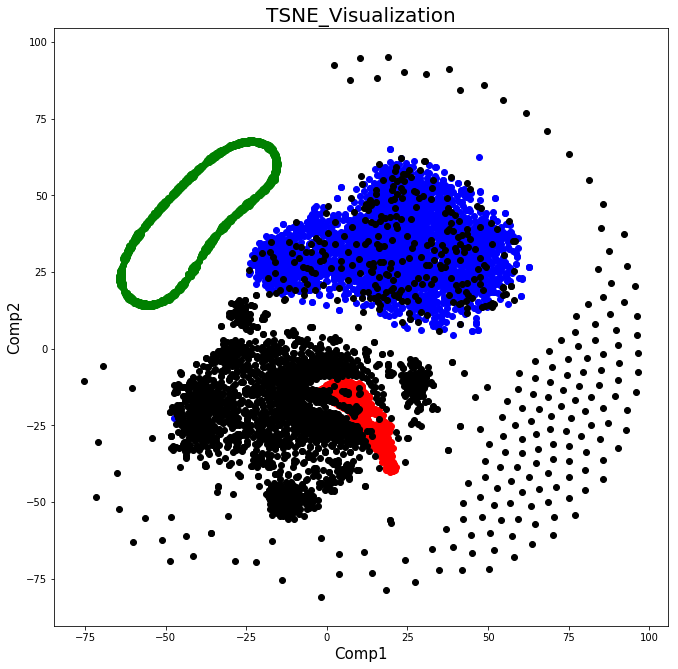

In [10]:
fig, ax = plt.subplots(figsize = (11, 11))
red = grp_info == 0
green = grp_info == 1
blue = grp_info == 2
black = grp_info == 3
ax.scatter(X_embedd1[red, 0], X_embedd1[red, 1], c = "r")
ax.scatter(X_embedd1[green, 0], X_embedd1[green, 1], c = "g")
ax.scatter(X_embedd1[blue, 0], X_embedd1[blue, 1], c = 'b')
ax.scatter(X_embedd1[black, 0], X_embedd1[black, 1], c = 'k' )
ax.set_title('TSNE_Visualization', fontsize = 20)
ax.set_xlabel('Comp1', fontsize = 15)
ax.set_ylabel('Comp2', fontsize = 15)
plt.axis('tight')

(-0.5012225887437253,
 0.6409197726525497,
 -0.5977259677414383,
 0.43531321057421807)

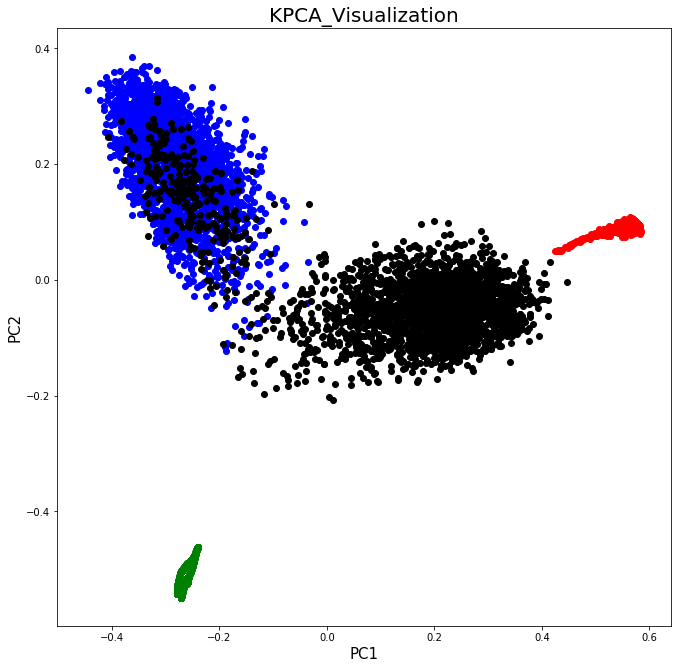

In [11]:
#Kernel PCA:
kpca = KernelPCA(n_components=2, kernel='rbf')
X_embedd2 = kpca.fit_transform(new_sample)
fig, ax = plt.subplots(figsize = (11, 11))
red = grp_info == 0
green = grp_info == 1
blue = grp_info == 2
black = grp_info == 3
ax.scatter(X_embedd2[red, 0], X_embedd2[red, 1], c = "r")
ax.scatter(X_embedd2[green, 0], X_embedd2[green, 1], c = "g")
ax.scatter(X_embedd2[blue, 0], X_embedd2[blue, 1], c = 'b')
ax.scatter(X_embedd2[black, 0], X_embedd2[black, 1], c = 'k' )
ax.set_title('KPCA_Visualization', fontsize = 20)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
plt.axis('tight')

(-98.08982212049466, 90.56423394308933, -82.04526780281559, 73.09985034732418)

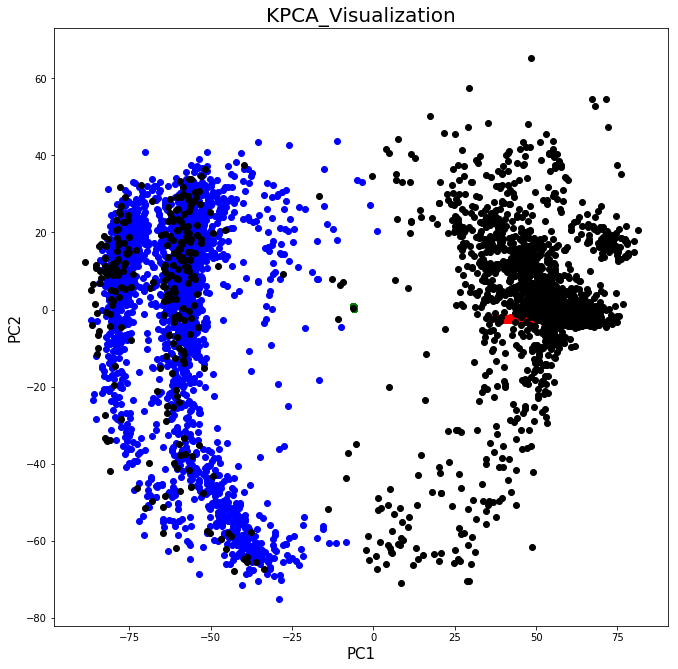

In [14]:
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
#X_embedd3 = Isomap(n_neighbors = 50, n_components = 2).fit_transform(new_sample)
fig, ax = plt.subplots(figsize = (11, 11))
red = grp_info == 0
green = grp_info == 1
blue = grp_info == 2
black = grp_info == 3
ax.scatter(X_embedd3[red, 0], X_embedd3[red, 1], c = "r")
ax.scatter(X_embedd3[green, 0], X_embedd3[green, 1], c = "g")
ax.scatter(X_embedd3[blue, 0], X_embedd3[blue, 1], c = 'b')
ax.scatter(X_embedd3[black, 0], X_embedd3[black, 1], c = 'k' )
ax.set_title('KPCA_Visualization', fontsize = 20)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
plt.axis('tight')

## Perform Anomaly detection on the cell populations via the reconstruction error checking:

### Rank the reconstruction error: